In [3]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import numpy as np
from astropy.table import QTable
from astropy import units as u
import astropy.cosmology.units as cu
from matplotlib import pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from scipy.optimize import brentq

from nfw_profile_heating import NFWProfile

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)


In [170]:
def load_clusters0(nrows=None, dataset='REFLEX'):
    skipfooter=0 if nrows else 1
    mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)
    mcxccls.columns=mcxccls.columns.str.strip()

    selected_cls=mcxccls[mcxccls['Sub-Cat'].str.strip()==dataset]

    cls_data={'M500':selected_cls['M500'],
          'L500':selected_cls['L500'],
          'R500':selected_cls['R500'],
          'z':selected_cls['R500']
         }
    units={
        'M500': 1e14*u.Msun,
        'L500': 1e37*u.W,
        'R500':u.Mpc,
        'z': None
    }

    cls_table=QTable(cls_data, units=units)

    with open ('data/'+dataset+'.p', 'rb') as fp:
        L_uncertainties=np.array(pickle.load(fp))
    L_uncertainties_conv=(L_uncertainties*1e37*u.W).to(u.erg / u.s).value

    n = nrows or len(L_uncertainties_conv)

    nfws = [NFWProfile(
        cls_table['z'][i], 
        M500=cls_table['M500'][i], 
        R500=cls_table['R500'][i]
        ) for i in range(n)]

    return nfws

In [2]:
from mcxc_clusters_as_nfw import load_clusters
nfws = load_clusters()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/eleanorstuart/Desktop/krisp/thermo-idm/mcxc_clusters_as_nfw.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)


In [42]:
net_heating = [(nfw.total_heating_rate(
                0.015*nfw.R500, 
                nfw.R500, 
                0.3*nfw.R500) 
              - nfw.total_cooling_rate(0.015*nfw.R500, 
                nfw.R500)).to(u.erg/u.s).value for nfw in nfws]

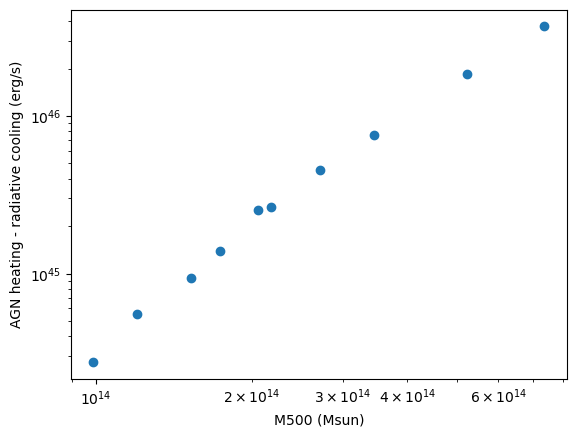

In [43]:
plt.scatter([nfw.M500.to(u.Msun).value for nfw in nfws],net_heating)
plt.xlabel('M500 (Msun)')
plt.ylabel('AGN heating - radiative cooling (erg/s)')
plt.xscale('log')
plt.yscale('log')

In [90]:
sigma0 = 1e-26*u.cm**2
mchi = 1e-2*u.GeV
dm_cooling_rates_26 = [nfw.integrated_dm_cooling_rate(0.015*nfw.R500,
                                                   nfw.R500,
                                                   sigma0,
                                                   mchi
                                                  ).to(u.erg/u.s).value for nfw in nfws]

In [95]:
dm_cooling_rates_27 = [nfw.integrated_dm_cooling_rate(0.015*nfw.R500,
                                                   nfw.R500,
                                                   1e-26*u.cm**2,
                                                   mchi
                                                  ).to(u.erg/u.s).value for nfw in nfws]
dm_cooling_rates_25 = [nfw.integrated_dm_cooling_rate(0.015*nfw.R500,
                                                   nfw.R500,
                                                   1e-25*u.cm**2,
                                                   mchi
                                                  ).to(u.erg/u.s).value for nfw in nfws]

In [97]:
dm_cooling_rates_27, dm_cooling_rates_25

([8.86295682409505e+45,
  1.9824389827945414e+44,
  4.949350951664956e+44,
  1.6793032813260348e+45,
  8.580111922902904e+44,
  9.409913363726485e+44,
  3.0449755774491505e+45,
  2.1051172404139945e+46,
  1.142016975917466e+44,
  3.4618430031988037e+44],
 [8.862956824095052e+46,
  1.9824389827945414e+45,
  4.9493509516649554e+45,
  1.6793032813260347e+46,
  8.580111922902905e+45,
  9.409913363726485e+45,
  3.0449755774491505e+46,
  2.1051172404139946e+47,
  1.142016975917466e+45,
  3.461843003198804e+45])

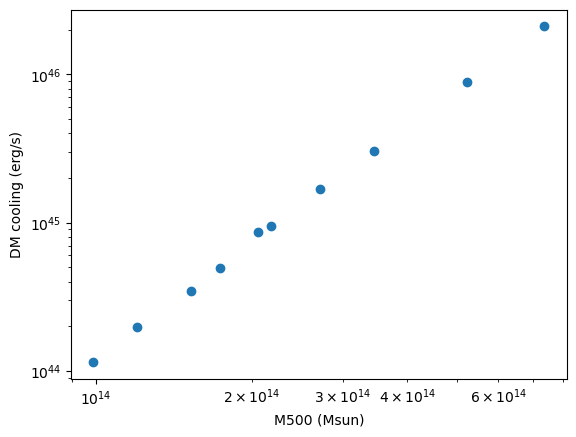

In [87]:
plt.scatter([nfw.M500.to(u.Msun).value for nfw in nfws],np.array(dm_cooling_rates))
plt.xlabel('M500 (Msun)')
plt.ylabel('DM cooling (erg/s)')
plt.xscale('log')
plt.yscale('log')

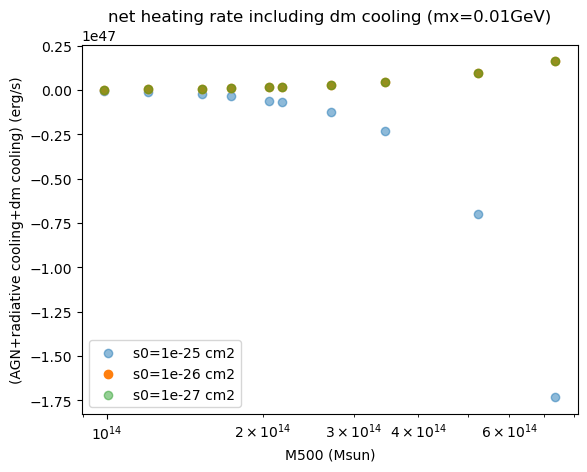

In [109]:
plt.scatter([nfw.M500.to(u.Msun).value for nfw in nfws],np.subtract(net_heating, dm_cooling_rates_25), label="s0=1e-25 cm2", alpha=0.5)
plt.scatter([nfw.M500.to(u.Msun).value for nfw in nfws],np.subtract(net_heating, dm_cooling_rates), label="s0=1e-26 cm2")

plt.scatter([nfw.M500.to(u.Msun).value for nfw in nfws],np.subtract(net_heating, dm_cooling_rates_27), label="s0=1e-27 cm2", alpha=0.5)

plt.xlabel('M500 (Msun)')
plt.ylabel('(AGN+radiative cooling+dm cooling) (erg/s)')
plt.xscale('log')
#plt.yscale('symlog')
plt.title('net heating rate including dm cooling (mx=0.01GeV)')
plt.legend()

In [82]:
net_heating, dm_cooling_rates

([1.8533917197043716e+46,
  5.5618930256735205e+44,
  1.3894552066310285e+45,
  4.5378541399127146e+45,
  2.535360682296852e+45,
  2.65843387358006e+45,
  7.534084857635063e+45,
  3.7168579624385327e+46,
  2.729110478635851e+44,
  9.408001312124557e+44],
 [8.86295682409505e+45,
  1.9824389827945414e+44,
  4.949350951664956e+44,
  1.6793032813260348e+45,
  8.580111922902904e+44,
  9.409913363726485e+44,
  3.0449755774491505e+45,
  2.1051172404139945e+46,
  1.142016975917466e+44,
  3.4618430031988037e+44])

In [23]:
sample_nfw = nfws[10]
sample_nfw.M500, sample_nfw.R500, sample_nfw.L500

(<Quantity 3.5275 1e+14 solMass>,
 <Quantity 1.0263 Mpc>,
 <Quantity 2.872451 1e+37 W>)

In [24]:
[nfw.L500 for nfw in nfws]

[<Quantity 6.107094 1e+37 W>,
 <Quantity 0.441862 1e+37 W>,
 <Quantity 0.846881 1e+37 W>,
 <Quantity 1.809494 1e+37 W>,
 <Quantity 1.086002 1e+37 W>,
 <Quantity 1.236332 1e+37 W>,
 <Quantity 2.827248 1e+37 W>,
 <Quantity 11.818114 1e+37 W>,
 <Quantity 0.326305 1e+37 W>,
 <Quantity 0.692442 1e+37 W>,
 <Quantity 2.872451 1e+37 W>,
 <Quantity 0.49467 1e+37 W>,
 <Quantity 2.164603 1e+37 W>,
 <Quantity 1.404549 1e+37 W>,
 <Quantity 1.253723 1e+37 W>,
 <Quantity 0.072779 1e+37 W>,
 <Quantity 5.100085 1e+37 W>,
 <Quantity 2.734146 1e+37 W>,
 <Quantity 6.907787 1e+37 W>,
 <Quantity 1.438047 1e+37 W>,
 <Quantity 3.393306 1e+37 W>,
 <Quantity 1.437223 1e+37 W>,
 <Quantity 0.734662 1e+37 W>,
 <Quantity 1.460216 1e+37 W>,
 <Quantity 5.160525 1e+37 W>,
 <Quantity 2.779734 1e+37 W>,
 <Quantity 1.156778 1e+37 W>,
 <Quantity 0.192363 1e+37 W>,
 <Quantity 0.491051 1e+37 W>,
 <Quantity 0.815085 1e+37 W>,
 <Quantity 0.181484 1e+37 W>,
 <Quantity 0.467516 1e+37 W>,
 <Quantity 4.935834 1e+37 W>,
 <Quantity

In [6]:
sample_nfw.get_Linj_from_L500()

<Quantity 2.96874235e+44 erg / s>

In [8]:
heatings=[n.total_heating_rate(0.001*n.R500, 1*n.R500, rc=0.1*n.R500).value for n in nfws]

In [9]:
coolings = [n.total_cooling_rate(0.001*n.R500, 1*n.R500).value for n in nfws]

In [10]:
diff = np.subtract(heatings, coolings)

In [11]:
diff

array([-6.20204275e+45, -3.28907325e+44, -7.39494782e+44, -1.83387278e+45,
       -1.08034089e+45, -1.19478505e+45, -2.87441048e+45, -1.15784718e+46,
       -1.94574789e+44, -5.59929897e+44, -3.03813930e+45, -3.88292109e+44,
       -2.14914849e+45, -1.35176339e+45, -1.24613890e+45,  2.94531927e+43,
       -7.03538931e+45, -3.04856567e+45, -6.33741587e+45, -1.40142817e+45,
       -3.89747453e+45, -1.58000330e+45, -6.47100228e+44, -1.57396267e+45,
       -5.10586058e+45, -2.65033417e+45, -1.04685155e+45, -6.97472744e+43,
       -3.80509354e+44, -6.96555760e+44, -6.54583754e+43, -3.60979007e+44,
       -4.64293341e+45, -4.91976736e+45, -7.00503301e+44,  3.03688164e+43,
       -6.02571123e+45, -1.93230381e+45, -1.75964141e+44, -2.07524059e+45,
       -4.46344736e+45,  2.88084109e+43, -1.17230783e+45, -4.37092350e+45,
       -2.83223660e+43, -1.65544890e+45, -6.58915385e+44, -2.05400403e+44,
       -9.83170734e+45, -4.33469441e+45, -2.73810455e+44, -6.32227397e+45,
       -4.35066955e+44, -

In [12]:
masses = [n.M500.to(u.Msun).value for n in nfws]

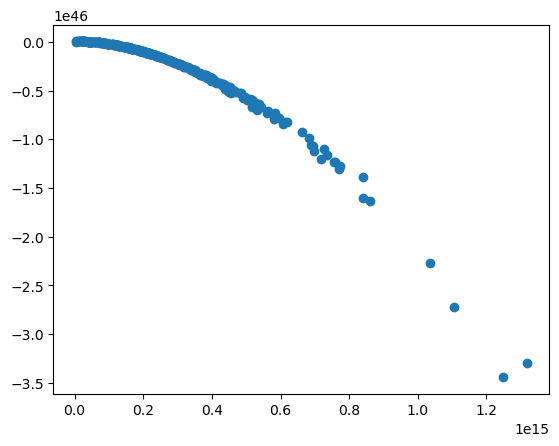

In [13]:
plt.scatter(masses, diff)

(0.0, 1e+45)

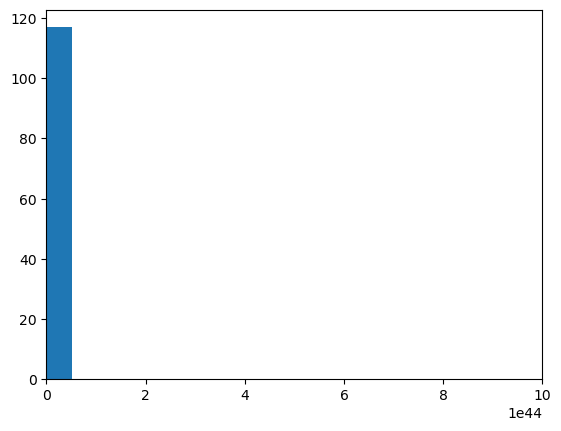

In [14]:
plt.hist(diff, bins=50)
plt.xlim(0, 1e45)

In [15]:
diff.shape

(335,)

In [16]:
mchi = np.logspace(-6, 0)*u.GeV
mchi_2comp = np.logspace(-6, 2)*u.GeV

In [25]:
sigma0s = [sample_nfw.sigma0_from_mchi(m).value for m in mchi]


In [26]:
sigma0s_f01 = [sample_nfw.sigma0_from_mchi(m, f_chi=0.1).value for m in mchi]

In [27]:
sigma0s_f001 = [sample_nfw.sigma0_from_mchi(m, f_chi=0.01).value for m in mchi]

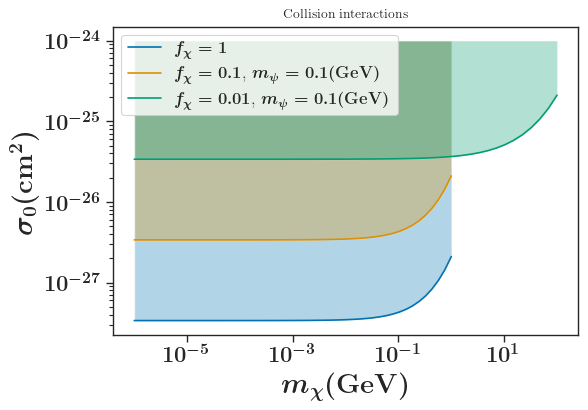

In [28]:
from plotting import paper_plot
paper_plot()
plt.loglog(mchi, sigma0s, label="$f_{{\chi}}={1}$")
plt.loglog(mchi, sigma0s_f01, label="$f_{{\chi}}={0.1}$, $m_{{\psi}}=0.1 \mathrm{ (GeV)}$")
plt.loglog(mchi_2comp, sigma0s_f001, label="$f_{{\chi}}={0.01}$, $m_{{\psi}}=0.1 \mathrm{ (GeV)}$")
plt.fill_between(
                    mchi.value,
                    sigma0s,
                    y2=1e-24,
                    alpha=0.3,
                )
plt.fill_between(mchi.value,sigma0s_f01,y2=1e-24,alpha=0.3,)
plt.fill_between(mchi_2comp.value,sigma0s_f001,y2=1e-24,alpha=0.3,)
plt.xlabel(r"$m_{\chi} \mathrm{(GeV)}$")
plt.ylabel(r"$\sigma_0 (\mathrm{cm}^2)$")
plt.title('Collision interactions')
plt.legend()
#plt.ylim(1e-26, np.power(10, -22.5))

Text(0.5, 1.0, 'n=0')

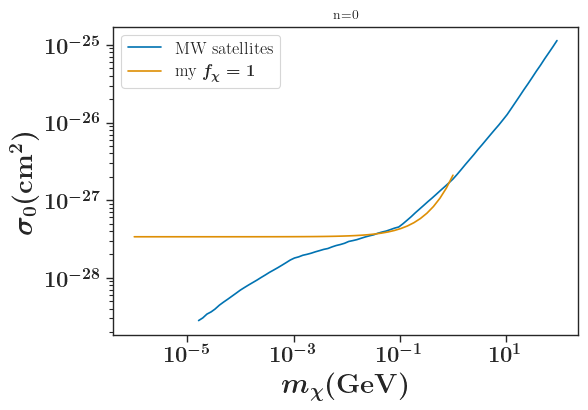

In [29]:
maamari = pd.read_csv('data/maamari_2021_constraint.csv', header=None)
plt.loglog(maamari[0], maamari[1], label="MW satellites")
plt.loglog(mchi, sigma0s, label="my $f_{{\chi}}={1}$")
plt.legend()
plt.xlabel(r"$m_{\chi} \mathrm{(GeV)}$")
plt.ylabel(r"$\sigma_0 (\mathrm{cm}^2)$")
plt.title('n=0')

In [30]:
sigma0s_n2_f1 = [sample_nfw.sigma0_from_mchi(m, n=-2, f_chi=1).value for m in mchi]

In [31]:
sigma0s_n2_f01 = [sample_nfw.sigma0_from_mchi(m, n=-2, f_chi=0.1).value for m in mchi]

In [32]:
sigma0s_n2_f001 = [sample_nfw.sigma0_from_mchi(m, n=-2, f_chi=0.01).value for m in mchi]

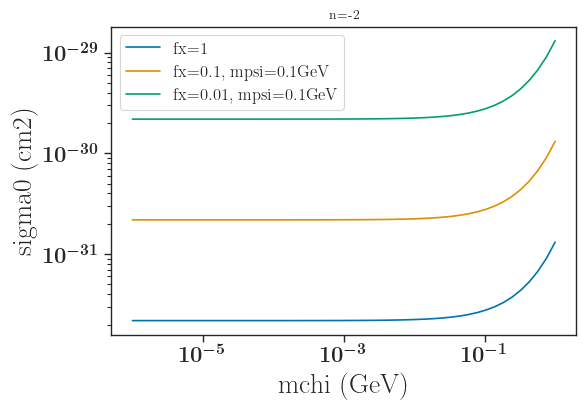

In [33]:
plt.loglog(mchi, sigma0s_n2_f1, label="fx=1")
plt.loglog(mchi, sigma0s_n2_f01, label="fx=0.1, mpsi=0.1GeV")
plt.loglog(mchi, sigma0s_n2_f001, label="fx=0.01, mpsi=0.1GeV")
plt.xlabel('mchi (GeV)')
plt.ylabel('sigma0 (cm2)')
plt.title('n=-2')
plt.legend()

In [34]:
sigma0s_n4_f1 = [sample_nfw.sigma0_from_mchi(m, n=-4, f_chi=1).value for m in mchi]

In [35]:
sigma0s_n4_f01 = [sample_nfw.sigma0_from_mchi(m, n=-4, f_chi=0.1).value for m in mchi]

In [36]:
sigma0s_n4_f001 = [sample_nfw.sigma0_from_mchi(m, n=-4, f_chi=0.01).value for m in mchi]

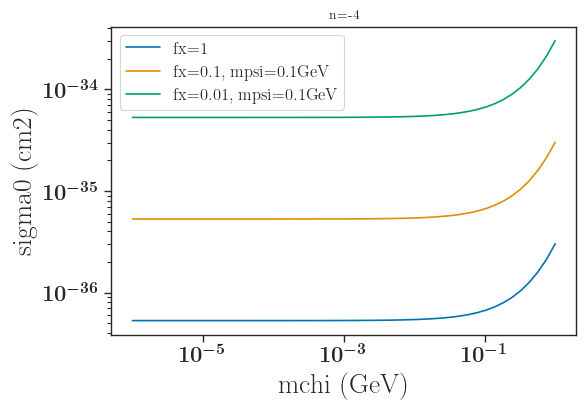

In [37]:
plt.loglog(mchi, sigma0s_n4_f1, label="fx=1")
plt.loglog(mchi, sigma0s_n4_f01, label="fx=0.1, mpsi=0.1GeV")
plt.loglog(mchi, sigma0s_n4_f001, label="fx=0.01, mpsi=0.1GeV")
plt.xlabel('mchi (GeV)')
plt.ylabel('sigma0 (cm2)')
plt.title('n=-4')
plt.legend()

In [38]:
sigma0s_np2_f1 = [sample_nfw.sigma0_from_mchi(m, n=2, f_chi=1).value for m in mchi]

In [39]:
sigma0s_np2_f01 = [sample_nfw.sigma0_from_mchi(m, n=2, f_chi=0.1).value for m in mchi]

In [40]:
sigma0s_np2_f001 = [sample_nfw.sigma0_from_mchi(m, n=2, f_chi=0.01).value for m in mchi]

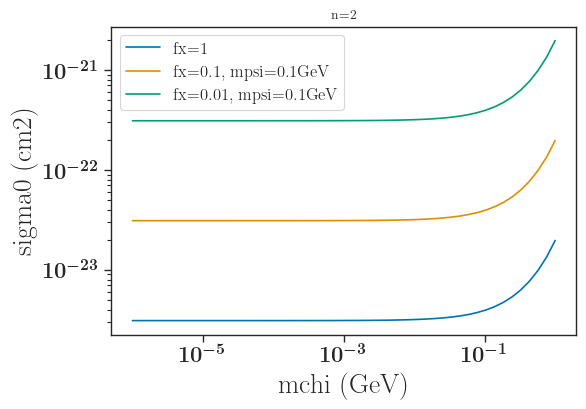

In [41]:
plt.loglog(mchi, sigma0s_np2_f1, label="fx=1")
plt.loglog(mchi, sigma0s_np2_f01, label="fx=0.1, mpsi=0.1GeV")
plt.loglog(mchi, sigma0s_np2_f001, label="fx=0.01, mpsi=0.1GeV")
plt.xlabel('mchi (GeV)')
plt.ylabel('sigma0 (cm2)')
plt.title('n=2')
plt.legend()

In [42]:
sigma0s_np4_f1 = [sample_nfw.sigma0_from_mchi(m, n=4, f_chi=1).value for m in mchi]
sigma0s_np4_f01 = [sample_nfw.sigma0_from_mchi(m, n=4, f_chi=0.1).value for m in mchi]
sigma0s_np4_f001 = [sample_nfw.sigma0_from_mchi(m, n=4, f_chi=0.01).value for m in mchi]

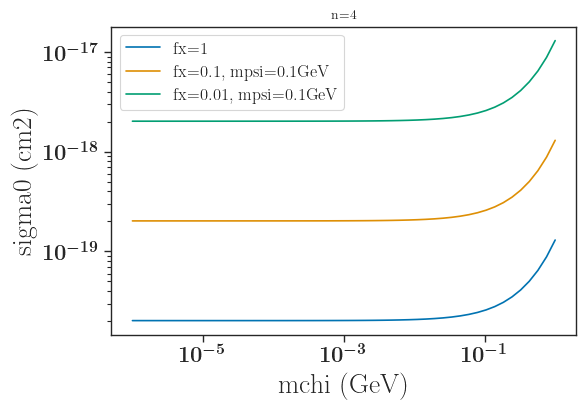

In [43]:
plt.loglog(mchi, sigma0s_np4_f1, label="fx=1")
plt.loglog(mchi, sigma0s_np4_f01, label="fx=0.1, mpsi=0.1GeV")
plt.loglog(mchi, sigma0s_np4_f001, label="fx=0.01, mpsi=0.1GeV")
plt.xlabel('mchi (GeV)')
plt.ylabel('sigma0 (cm2)')
plt.title('n=4')
plt.legend()